
# Liquidity in Africa – Nigeria Stablecoin Case Study

**Objective:** Support LAVA's Technical Research Analyst task by pairing onchain + offchain data to study **where liquidity is sourced** and **how efficiently it is used**, with a concrete **Nigeria** focus on stablecoin adoption.

> Marine engineering lens: treat liquidity like a flow network — identify sources (tanks), pipes (rails), valves (policies), bottlenecks (frictions), and recirculation (reuse of capital).


In [15]:

# --- Setup ---

# File and System Operations:
import os
import json

# Time and Date Handling:
import time
from datetime import datetime

# Data Manipukation:
import pandas as pd
import numpy as np

#  Networking and Web Requests:
import requests

# Data Manipulation
import matplotlib.pyplot as plt
import seaborn as sns

# Mathematics:
import math
# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)

# Paths
BASE_DIR = os.path.abspath(os.path.join(os.getcwd()))
DATA_RAW = os.path.join(BASE_DIR, "data", "raw")
DATA_PRO = os.path.join(BASE_DIR, "data", "processed")
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PRO, exist_ok=True)

print("Base dir:", BASE_DIR)


Base dir: C:\Users\DELL\15. LAVA Project\LAVA-Project--Investigating-Liquidity-in-Africa



## Data Sources (this notebook)

1. **World Bank – Remittances (Offchain)**  
   - Indicator: `BX.TRF.PWKR.CD.DT` (Personal remittances received, current US$)  
   - Country: `NGA` (Nigeria)

2. **Google Trends – Interest Over Time (Offchain proxy for behavior)**  
   - Region: `NG`  
   - Queries: `"USDT"`, `"crypto"`, `"binance"`, `"p2p"`, `"dollar rate"`

3. **Dune Analytics – Stablecoin Transfers (Onchain, optional)**  
   - Example: USDT (ERC20) contract `0xdAC17F958D2ee523a2206206994597C13D831ec7`  
   - Aggregate daily transfer amounts to understand macro flows (global), then align with Nigeria offchain context.


### World Bank: Nigeria Remittances (NGA)

In [18]:

def fetch_worldbank_indicator(country: str, indicator: str) -> pd.DataFrame:
    """Fetches a World Bank indicator time series for a given country.
    country: ISO3 country code (e.g., 'NGA')
    indicator: e.g., 'BX.TRF.PWKR.CD.DT'
    Returns a tidy DataFrame with columns: ['date', 'value'] sorted by date asc.
    """
    url = f"https://api.worldbank.org/v2/country/{country}/indicator/{indicator}?format=json&per_page=20000"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()
    if not isinstance(data, list) or len(data) < 2:
        raise ValueError("Unexpected World Bank response format")
    rows = data[1]
    recs = []
    for row in rows:
        val = row.get('value', None)
        date = row.get('date', None)
        if date is not None:
            recs.append({'date': int(date), 'value': float(val) if val is not None else None})
    df = pd.DataFrame(recs).sort_values('date').reset_index(drop=True)
    return df

wb_remit = fetch_worldbank_indicator(country="NGA", indicator="BX.TRF.PWKR.CD.DT")
wb_remit.to_csv(os.path.join(DATA_RAW, "worldbank_remittances_nga.csv"), index=False)
wb_remit.tail()


,date,value
60,2020,1.720755e+10
61,2021,1.948340e+10
62,2022,2.012761e+10
63,2023,1.954955e+10
64,2024,2.129296e+10


### Google Trends: Interest Over Time (Nigeria)

In [20]:

# Note: Requires internet access. If running locally, ensure you're connected.
try:
    from pytrends.request import TrendReq
    pytrends = TrendReq(hl='en-US', tz=0)
    kw_list = ["USDT", "crypto", "binance", "p2p", "dollar rate"]
    pytrends.build_payload(kw_list, timeframe='today 5-y', geo='NG')
    trends = pytrends.interest_over_time().reset_index()
    if 'isPartial' in trends.columns:
        trends = trends.drop(columns=['isPartial'])
    trends.to_csv(os.path.join(DATA_RAW, "google_trends_ng.csv"), index=False)
    trends.tail()
except Exception as e:
    print("Google Trends fetch skipped or failed:", e)
    trends = pd.DataFrame()


### Dune: Stablecoin Transfers (USDT ERC20 example) — Optional

In [22]:

# This cell sketches how to call Dune's API. Replace QUERY_ID with your own Dune query id.
# The query should aggregate daily USDT transfer amounts from erc20 transfer events.
# Example (pseudocode SQL for Dune v2 datasets):
#   SELECT
#     date_trunc('day', evt_block_time) AS day,
#     SUM(value)/1e6 AS usdt_transferred  -- USDT has 6 decimals
#   FROM erc20_ethereum.evt_Transfer
#   WHERE contract_address = '\x...dAC17F958D2ee523a2206206994597C13D831ec7'
#   GROUP BY 1 ORDER BY 1;

DUNE_API_KEY = os.getenv("DUNE_API_KEY", "")
QUERY_ID = os.getenv("DUNE_QUERY_ID", "")  # put your query id here

def dune_results(query_id: str, api_key: str) -> pd.DataFrame:
    if not query_id or not api_key:
        print("Set DUNE_API_KEY and DUNE_QUERY_ID to fetch onchain data.")
        return pd.DataFrame()

    # Start execution
    headers = {"x-dune-api-key": api_key, "accept": "application/json", "content-type": "application/json"}
    exec_url = f"https://api.dune.com/api/v1/query/{query_id}/execute"
    res = requests.post(exec_url, headers=headers, json={})
    res.raise_for_status()
    job = res.json()
    job_id = job.get("execution_id")
    if not job_id:
        raise RuntimeError("Dune: no execution_id returned")

    # Poll for completion
    result_url = f"https://api.dune.com/api/v1/execution/{job_id}/results"
    for _ in range(60):
        r = requests.get(result_url, headers=headers)
        if r.status_code == 200:
            out = r.json()
            rows = out.get("result", {}).get("rows", [])
            return pd.DataFrame(rows)
        time.sleep(3)
    raise TimeoutError("Dune: result polling timeout")

dune_df = dune_results(QUERY_ID, DUNE_API_KEY)
if not dune_df.empty:
    # Try to coerce time column
    for c in dune_df.columns:
        if "time" in c or "date" in c or c.lower() in ["day", "dt", "timestamp"]:
            try:
                dune_df[c] = pd.to_datetime(dune_df[c])
            except Exception:
                pass
    dune_df.to_csv(os.path.join(DATA_RAW, "dune_usdt_transfers.csv"), index=False)
dune_df.head() if not dune_df.empty else dune_df


Set DUNE_API_KEY and DUNE_QUERY_ID to fetch onchain data.


""


## Align & Merge (Offchain vs Onchain Proxies)

In [24]:

# Convert World Bank annual data to datetime (year-end) and forward-fill to monthly for alignment
wb = wb_remit.copy()
wb['date'] = pd.to_datetime(wb['date'].astype(str) + "-12-31")
wb = wb.rename(columns={'value': 'remittances_usd'}).set_index('date').sort_index()
wb_m = wb.resample('M').ffill().reset_index()

# Trends (already time-based)
if not trends.empty:
    trends_m = trends.rename(columns={'date': 'dt'})
    trends_m = trends_m.rename(columns={c: c.replace(" ", "_").lower() for c in trends_m.columns})
else:
    trends_m = pd.DataFrame()

# Dune (daily) if present
if not dune_df.empty:
    # Heuristic: look for a day/date/datetime column
    time_col = None
    for c in dune_df.columns:
        if c.lower() in ["day", "date", "dt", "timestamp"] or "time" in c.lower():
            time_col = c
            break
    if time_col:
        dd = dune_df.copy()
        dd[time_col] = pd.to_datetime(dd[time_col])
        dd = dd.rename(columns={time_col: 'dt'}).sort_values('dt')
        dune_d = dd
    else:
        dune_d = pd.DataFrame()
else:
    dune_d = pd.DataFrame()

# Example merge: monthly view
dfm = wb_m.rename(columns={'date': 'dt'})
if not trends_m.empty:
    dfm = pd.merge_asof(dfm.sort_values('dt'), trends_m.sort_values('dt'), on='dt', direction='nearest')
if not dune_d.empty:
    dune_m = dune_d.set_index('dt').resample('M').sum().reset_index()
    dfm = pd.merge_asof(dfm.sort_values('dt'), dune_m.sort_values('dt'), on='dt', direction='nearest')

dfm.to_csv(os.path.join(DATA_PRO, "merged_monthly.csv"), index=False)
dfm.tail()


,dt,remittances_usd,usdt,crypto,binance,p2p,dollar_rate
764,2024-08-31,1.954955e+10,25,34,19,2,18
765,2024-09-30,1.954955e+10,22,34,18,3,15
766,2024-10-31,1.954955e+10,13,32,8,2,14
767,2024-11-30,1.954955e+10,18,33,12,3,24
768,2024-12-31,2.129296e+10,16,28,11,1,16


## Visualizations

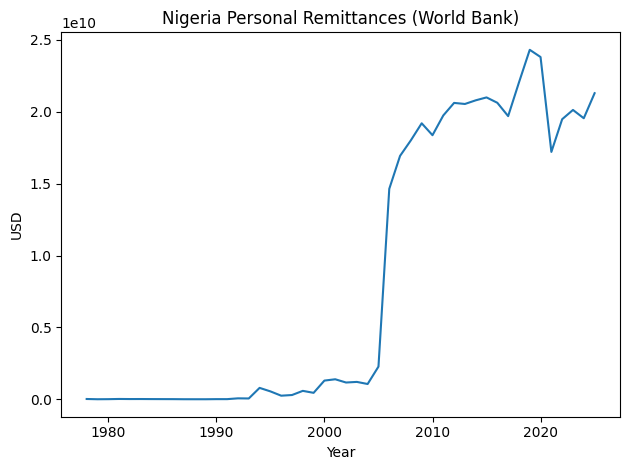

In [26]:

# 1) Remittances over time
if not wb_remit.empty:
    plt.figure()
    plt.plot(pd.to_datetime(wb_remit['date'].astype(str) + "-12-31"), wb_remit['value'])
    plt.title("Nigeria Personal Remittances (World Bank)")
    plt.xlabel("Year")
    plt.ylabel("USD")
    plt.tight_layout()
    plt.show()


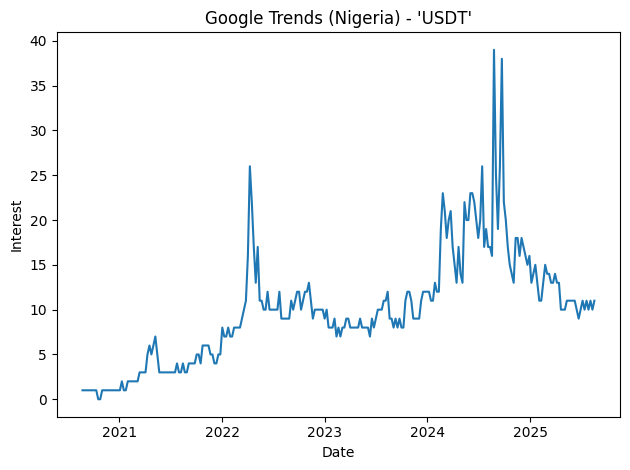

In [27]:

# 2) Google Trends: 'USDT' interest over time (if available)
if not trends.empty and 'USDT' in trends.columns:
    plt.figure()
    plt.plot(trends['date'], trends['USDT'])
    plt.title("Google Trends (Nigeria) - 'USDT'")
    plt.xlabel("Date")
    plt.ylabel("Interest")
    plt.tight_layout()
    plt.show()


In [28]:

# 3) Correlation snapshot (merged monthly)
if not dfm.empty:
    num_cols = dfm.select_dtypes(include=[np.number]).columns.tolist()
    corr = dfm[num_cols].corr()
    corr



## Efficiency Framework (Template)

Define an **efficiency score** for each rail (banks, mobile money, stablecoins) and country:

- **Cost** — FX spread + fees (lower is better)
- **Speed** — settlement time (faster is better)
- **Recycling** — % of capital that recirculates locally vs one-way outflows (higher is better)

Score each 0–1 then take a weighted average to get an overall efficiency score.


In [30]:

# Template scoring (placeholder values; replace with real measurements)
rails = pd.DataFrame({
    'rail': ['banks', 'mobile_money', 'stablecoins'],
    'cost_score': [0.4, 0.6, 0.8],
    'speed_score': [0.3, 0.7, 0.9],
    'recycling_score': [0.5, 0.6, 0.7],
})
weights = {'cost_score': 0.4, 'speed_score': 0.3, 'recycling_score': 0.3}
rails['efficiency'] = (
    rails['cost_score']*weights['cost_score'] +
    rails['speed_score']*weights['speed_score'] +
    rails['recycling_score']*weights['recycling_score']
)
rails


,rail,cost_score,speed_score,recycling_score,efficiency
0,banks,0.4,0.3,0.5,0.40
1,mobile_money,0.6,0.7,0.6,0.63
2,stablecoins,0.8,0.9,0.7,0.80



## Insights (Fill as you Analyze)
- Stablecoin interest spikes in Nigeria correspond to periods of FX stress (cross-validate with CBN policy timelines).
- Remittance inflows act as an offchain liquidity source; how much of this is converted to stablecoins?
- Which rails show the highest efficiency score, and where are the bottlenecks?
- What local nuances (P2P markets, mobile money limits) change the picture vs Kenya or South Africa?
